# General notes

# SDG Corpus Prep

Source: https://unstats.un.org/sdgs/indicators/indicators-list/

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 150)
import numpy as np


# Ingest
DC = pd.read_excel('sdg_meta.xlsx', sheet_name = 'DC')[['Goal', 'Target', 'Indicator']].drop_duplicates()
MD = pd.read_excel('sdg_meta.xlsx', sheet_name = 'MD')[['Goal', 'Target', 'Indicator']].drop_duplicates()
VA = pd.read_excel('sdg_meta.xlsx', sheet_name = 'VA')[['Goal', 'Target', 'Indicator']].drop_duplicates()
ALL = pd.concat([DC, MD, VA]).drop_duplicates().reset_index(drop = True)
ALL = ALL.replace('\n', '')


# # Create liss of goals, targets, indicators
# GOALS = list(set(ALL.apply(lambda row: row['Goal'].replace('Goal ', '') + ' ' + row['Target'] if str(row['Goal']).startswith('Goal') else None, axis = 1).dropna().values))
# TARGETS = list(set(ALL.apply(lambda row: row['Goal'] if not str(row['Goal']).startswith('Goal') and '.x' not in str(row['Goal']) else None, axis = 1).dropna().values))
# INDICATORS = ALL.Indicator.dropna().values



# # Define dataframes
# GOALS = pd.DataFrame(columns = ['Goal'], data = GOALS)
# GOALS['Goal No.'] = GOALS.Goal.apply(lambda x: int(x.split()[0]))

# TARGETS = pd.DataFrame(columns = ['Target'], data = TARGETS)
# TARGETS['Goal No.'] = TARGETS.Target.apply(lambda x: int(x.split('.')[0]))
# TARGETS['Target No.'] = TARGETS.Target.apply(lambda x: x.split()[0])

# INDICATORS = pd.DataFrame(columns = ['Indicator'], data = INDICATORS)
# INDICATORS['Target No.'] = INDICATORS.Indicator.apply(lambda x: '.'.join(x.split('.')[:2]))
# INDICATORS['Indicator No.'] = INDICATORS.Indicator.apply(lambda x: x.split()[0])


# # Join all; reorganize columns and drop goal numbers from text columns.
# SDGS = GOALS.merge(TARGETS).merge(INDICATORS)[['Goal No.', 'Goal', 'Target No.', 'Target', 'Indicator No.', 'Indicator']]
# for col in ['Goal', 'Target', 'Indicator']:
#     SDGS[col] = SDGS[col].apply(lambda x: ' '.join(x.split()[1:]))
# SDGS = SDGS.sort_values(by = ['Goal No.', 'Target No.', 'Indicator No.']).drop_duplicates().reset_index(drop = True)

# SDGS.to_csv('SDGS_prepped.csv', index = False)

# """
# Note - the below has had some manual modifications made.
# """

# SDGS = pd.read_csv('SDGS_prepped.csv')
# SDGS

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [2]:
# Filtering to subset of Climate SDGs
climate_sdgs = [6, 7, 11,12, 13, 14, 15]
SDGS = SDGS[SDGS['Goal No.'].isin(climate_sdgs)]

# Stack phrasing
SDG_Phrases = SDGS[['Goal No.', 'Goal', 'Target']].rename(columns = {'Target' : 'Phrase'}).drop_duplicates(subset = 'Phrase', keep = 'first').reset_index(drop = True)
SDG_Phrases = pd.concat([
    SDG_Phrases,
    SDGS[['Goal No.', 'Goal', 'Indicator']].rename(columns = {'Indicator' : 'Phrase'})
]).drop_duplicates(subset = 'Phrase', keep = 'first').reset_index(drop = True)
SDG_Phrases

,Goal No.,Goal,Phrase
0,6,Clean Water,"By 2030, achieve universal and equitable access to safe and affordable drinking water for all"
1,6,Clean Water,"By 2030, achieve access to adequate and equitable sanitation and hygiene for all and end open defecation, paying special attention to the needs of..."
2,6,Clean Water,"By 2030, improve water quality by reducing pollution, eliminating dumping and minimizing release of hazardous chemicals and materials, halving the..."
3,6,Clean Water,"By 2030, substantially increase water-use efficiency across all sectors and ensure sustainable withdrawals and supply of freshwater to address wat..."
4,6,Clean Water,"By 2030, implement integrated water resources management at all levels, including through transboundary cooperation as appropriate"
...,...,...,...
122,15,Life on Land,Proportion of traded wildlife that was poached or illicitly trafficked
123,15,Life on Land,Proportion of countries adopting relevant national legislation and adequately resourcing the prevention or control of invasive alien species
124,15,Life on Land,(a) Number of countries that have established national targets in accordance with or similar to Aichi Biodiversity Target 2 of the Strategic Plan ...
125,15,Life on Land,Official development assistance and public expenditure on conservation and sustainable use of biodiversity and ecosystems


In [3]:
SDG_Phrases[['Goal No.', 'Goal']].drop_duplicates()

,Goal No.,Goal
0,6,Clean Water
8,7,Affordable and Clean Energy
13,11,Sustainable Cities
22,12,Responsible Consumption and Production
33,13,Climate Action
37,14,Life Under Water
47,15,Life on Land


# Pulling from Legiscan

https://legiscan.com/gaits/documentation/legiscan




Note on statuses:
- 1 = Introduced
- 2 = Held
- 3 = Sent to Executive Branch
- 4 = Passed
- 5 = Vetoed
- 6 = Died

Probably will want to just look at those passed.


In [15]:
import requests
import pandas as pd


def get_bills(apikey, states):

    # Iterate states
    BILLS = []
    for stateid in states:

        print('Fetching {}...'.format(stateid))

        try:
            # Fetch bill data for state
            url = 'https://api.legiscan.com/?key={}&op=getMasterList&state={}'
            response = requests.get(url.format(apikey, stateid))
            response = response.json()['masterlist']

            # Iterate bills and add rows to dataframe
            for i in range(len(response) - 1):
                bill = response[str(i)]
                BILLS.append([stateid, bill['number'], bill['status'], bill['status_date'], bill['title'], bill['description']])
        except:
            print('Could not fetch {}'.format(stateid))

    # Add bills to dataframe
    BILLS = pd.DataFrame(columns = ['legislative_body', 'bill_number', 'status', 'status_date', 'title', 'description'], data = BILLS).fillna('')
    BILLS['status_date'] = pd.to_datetime(BILLS['status_date'])

    # Map status codes & filter to passed / signed legislation
    statuses = {1 : 'Introduced', 2 : 'Held', 3 : 'Passed', 4 : 'Signed', 5 : 'Vetoed', 6 : 'Died'}
    BILLS['status'] = BILLS.status.apply(lambda x: statuses[x] if x in statuses.keys() else 'Other')
    BILLS = BILLS[BILLS.status.isin(['Passed', 'Signed'])].reset_index(drop = True)

    return BILLS

apikey = '3450b965641ca5cf68d314cc3e375ad0'
# states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "DC", "US"]
states = ['NY']

# BILLS = get_bills(apikey, states)
# BILLS.to_csv('BILLS.csv', index = False)

BILLS = pd.read_csv('BILLS.csv')
BILLS['status_date'] = pd.to_datetime(BILLS['status_date'])



# Categorization

In [31]:
"""
Generate embeddings for SDGS and Bill titles / descriptions
"""
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v1')

# SDG_embeddings = model.encode(SDG_Phrases.Phrase)
SDG_Phrases['embedding'] = list(SDG_embeddings)

# BILL_embeddings = model.encode(BILLS.apply(lambda row: row['title'], axis = 1))
BILLS['embedding'] = list(BILL_embeddings)


In [90]:

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity


def categorize_bills(SDG_Phrases, BILLS):

    """
    Train KMeans on SDG Phrasing; predict on Bill titles / descriptions.
    """
    # Fit predict to SDG Embeddings
    kmeans = KMeans(n_clusters= len(SDG_embeddings), random_state=42)
    SDG_Phrases['SDG_cluster_num'] = kmeans.fit_predict(SDG_embeddings)

    # Predict on Bills
    BILLS['SDG_cluster_num'] = kmeans.predict(BILL_embeddings)


    # Join bills to SDGS and calculate similarities
    BILLS_SDGS = BILLS.merge(SDG_Phrases[['SDG_cluster_num', 'embedding', 'Goal No.', 'Goal']].rename(columns = {'embedding' : 'sdg_embedding', 'Goal' : 'Goal_preliminary'}))
    BILLS_SDGS['similarity'] = BILLS_SDGS.apply(lambda row:
                                                cosine_similarity(
                                                    row['embedding'].reshape(1, -1),
                                                    row['sdg_embedding'].reshape(1, -1)
                                                )[0][0], axis = 1)
    BILLS_SDGS = BILLS_SDGS.drop(columns = ['embedding', 'SDG_cluster_num', 'sdg_embedding'])

    return BILLS_SDGS, SDG_Phrases

BILLS_SDGS, SDG_Phrases = categorize_bills(SDG_Phrases, BILLS)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Verification & Thresholding

count    21035.000000
mean         0.334096
std          0.101313
min          0.076446
25%          0.262249
50%          0.335056
75%          0.402440
max          0.797761
Name: similarity, dtype: float64


<AxesSubplot: >

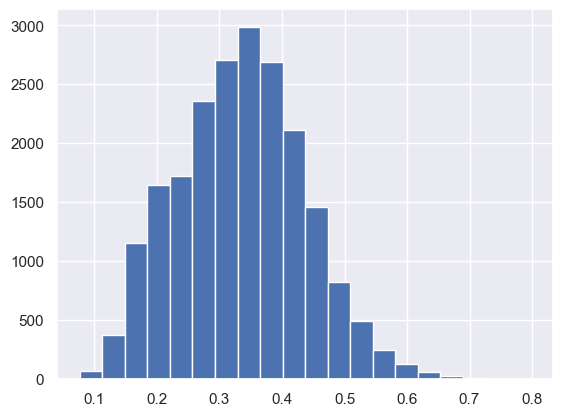

In [91]:
"""
Overall distribution of similarity
"""
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

print(BILLS_SDGS.similarity.describe())

BILLS_SDGS.similarity.hist(bins = 20)


In [92]:
BILLS_SDGS.groupby('Goal_preliminary').similarity.median()

Goal_preliminary
Affordable and Clean Energy                0.411340
Clean Water                                0.373622
Climate Action                             0.430097
Decent Work                                0.348002
End Poverty                                0.334369
Gender Equality                            0.330347
Global Partnerships                        0.332215
Good Health & Well-Being                   0.349990
Industry, Innovation, Infrastructure       0.342680
Life Under Water                           0.319589
Life on Land                               0.326033
Peace, Justice, and Strong Institutions    0.331216
Quality Education                          0.337687
Reduced Inequalities                       0.332589
Responsible Consumption and Production     0.342863
Sustainable Cities                         0.309370
Zero Hunger                                0.341322
Name: similarity, dtype: float32

In [93]:
SDG_sample = ['Affordable and Clean Energy', 'Climate Action', 'Gender Equality', 'Quality Education', 'Zero Hunger']
similarity_range = range(75, 0, -5)

row = []

for sim in similarity_range:
    TEMP = BILLS_SDGS[BILLS_SDGS.similarity >= sim/100].sort_values(by = 'similarity')
    col = [sim/100, str(np.round(100 * len(TEMP) / len(BILLS_SDGS), 2)) + '%']
    for sdg in SDG_sample:
        TEMP2 = TEMP[TEMP.Goal_preliminary == sdg].reset_index()
        if len(TEMP2) > 0:
            col.append(TEMP2.title[0])
        else:
            col.append('-')
    row.append(col)



"""
Cutoff notes
- Affordable and Clean Energy: 0.30
- Climate Action: 0.35
- Gender Equality: 0.45
- Quality Education: 0.40
- Zero Hunger: 0.40
"""


pd.DataFrame(columns = ['Similarity Threshold', 'Match Rate'] + SDG_sample, data = row)


,Similarity Threshold,Match Rate,Affordable and Clean Energy,Climate Action,Gender Equality,Quality Education,Zero Hunger
0,0.75,0.0%,-,-,-,-,-
1,0.70,0.03%,-,Implement State Climate Goals,-,-,-
2,0.65,0.14%,-,Implement State Climate Goals,Female Genital Mutilation Prohibition Act of 2023,Relative to requirements for literacy skill development in elementary grades.,-
3,0.60,0.68%,Relative to the use of renewable energy funds by the department of energy.,"An act relating to natural disaster government response, recovery, and resiliency",Eliminating child marriage.,Higher education; 2024-2025,Relative to food and agriculture.
4,0.55,2.01%,Energy Efficiency and Conservation Plans,"Adds climate change, sea-level rise and coastal resiliency to the analysis of data of the strategic plan for economic development policy.",Relative to AAPI Women’s Equal Pay Day.,Relates to the appropriation to the Workforce Development Council for fiscal year 2025.,Include shelterbelts as a factor affecting productivity in determining assessed value of agricultural land.
5,0.50,5.34%,Promoting the development of geothermal energy resources.,Greenhouse gases: climate corporate accountability: climate-related financial risk.,Requires the office for the prevention of domestic violence to conduct a study on domestic violence in the transgender community with a focus on B...,Relates to the appropriation to the Public Schools Educational Support Program for fiscal year 2025.,Appropriation; IHL - Alcorn State - Agricultural programs.
6,0.45,12.52%,Providing solar consumer protections.,Urge US EPA to withdraw proposed greenhouse gas emission rules,Sexual Assault Investigation Amendments,An Act For The Department Of Human Services - Division Of Developmental Disabilities Services Reappropriation.,An Act For The Department Of Agriculture - Arkansas Natural Resources Commission Appropriation For The 2024-2025 Fiscal Year.
7,0.40,25.75%,Public Utilities Commission: reports: telecommunications service: backup electricity.,Revised for 1st Substitute: Concerning executive sessions under the open public meetings act in order to comply with the climate commitment act.Or...,Provide and change authority for agreements by county boards,"Relating to revising, updating and streamlining the requirements governing the West Virginia Science, Technology, Engineering, and Mathematics Sch...",Food allergy awareness.
8,0.35,43.9%,Oil and gas leases: bankruptcy.,Energy: natural gas; penalties for natural gas safety violations; modify. Amends sec. 11 of 1969 PA 165 (MCL 483.161).,An Act For The Secretary Of State Reappropriation.,"A RESOLUTION honoring the Mayfield High School Cardinals football team, 2023 Kentucky High School Athletic Association Class 2A Champions.","Memorializing Governor Kathy Hochul to proclaim April 2024, as Organ and Tissue Donor Awareness Month in the State of New York, in conjunction wit..."
9,0.30,62.78%,California Utility Workers Appreciation Day.,Utah Communications Authority Modifications,County Sales and Use Tax Amendments,Honoring the Stark Public Royal Knights basketball team on winning the 2024 Ohio Special Olympics Winter Games Division 3 Championship.,Georgia Peanut Month; recognize March 2024


In [94]:
# If similarity is >0.40, accept the preliminary goal label
THRESHOLD = 0.40
BILLS_SDGS['Goal'] = BILLS_SDGS.apply(lambda row: row['Goal_preliminary'] if row['similarity'] >= THRESHOLD else '', axis = 1)
BILLS_SDGS_FILTERED = BILLS_SDGS[BILLS_SDGS.similarity >= THRESHOLD].reset_index(drop = True)

# Analysis

- Overall, how much legislative activity did each SDG see in 2024?
    - Total bills updated at Federal, State level
    - Total introduced, passed or signed
- What area(s) is each state focusing on the most? Least? Pick the states that have the largest volume of legislation.

In [95]:

pd.pivot_table(
    BILLS_SDGS_FILTERED,
    index = 'Goal',
    columns = 'legislative_body',
    aggfunc = 'size',
    fill_value=0)

legislative_body,AK,AR,AZ,CA,CO,CT,DC,DE,GA,HI,...,RI,SC,SD,US,UT,VT,WA,WI,WV,WY
Goal,,,,,,,,,,,,,,,,,,,,,
Affordable and Clean Energy,2,2,1,18,3,2,7,1,4,5,...,5,1,1,0,10,3,7,2,2,4
Clean Water,1,5,7,21,12,2,11,0,10,17,...,5,1,11,0,16,2,5,3,12,4
Climate Action,0,0,0,5,2,0,0,0,1,3,...,4,0,0,0,1,2,2,0,0,0
Decent Work,1,6,10,40,22,8,24,0,10,14,...,0,3,3,0,10,7,13,9,7,4
End Poverty,2,2,3,25,18,3,18,0,4,13,...,6,0,6,1,11,3,12,7,3,3
Gender Equality,0,0,4,31,3,5,3,0,14,8,...,8,1,8,0,15,5,5,1,3,2
Global Partnerships,1,2,4,23,13,3,7,2,8,26,...,4,0,3,1,7,3,5,2,10,2
Good Health & Well-Being,4,10,17,98,47,10,36,1,32,40,...,34,12,16,3,36,17,42,13,23,9
"Industry, Innovation, Infrastructure",0,7,4,17,3,0,7,0,7,14,...,7,3,3,1,4,1,2,0,2,2


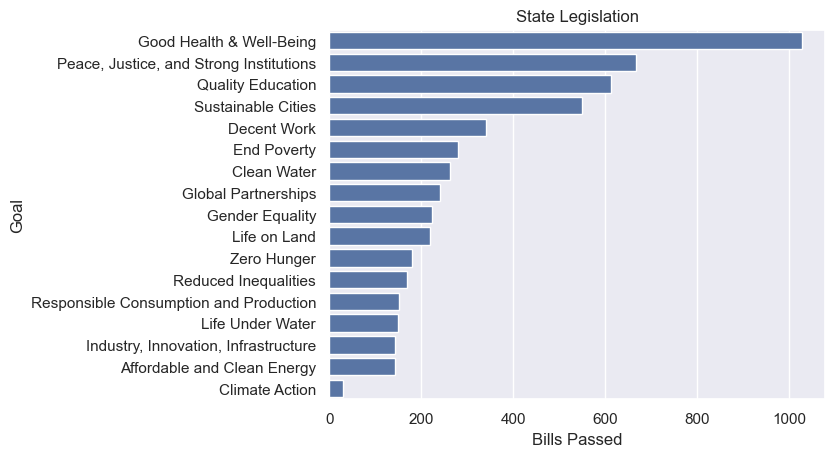

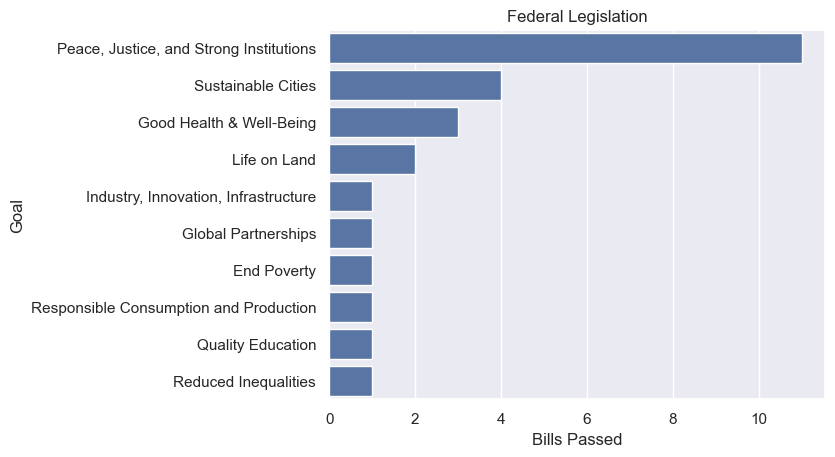

In [96]:
"""
How many bills were passed relating to each SDG at the State level? Federal?

Observations:
- At both the state & federal level, we see lots of legislative activity around "Peace, Justice and Strong Institutions". This goal addresses issues such as violence, crime, corruption, and discrimination.
- At the state level, we also see high activity around Good Health & Well-Being, Education, and Sustainable Cities.
"""

ax = sns.barplot(BILLS_SDGS_FILTERED[BILLS_SDGS_FILTERED.legislative_body != 'US'].Goal.value_counts(), orient='y')
ax.set_title("State Legislation")
ax.set_xlabel('Bills Passed')
plt.show()

ax = sns.barplot(BILLS_SDGS_FILTERED[BILLS_SDGS_FILTERED.legislative_body == 'US'].Goal.value_counts(), orient='y')
ax.set_title("Federal Legislation")
ax.set_xlabel('Bills Passed')
plt.show()

In [133]:
"""
Life on Land vs. Life Below Water: Does it make sense?
"""

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
gdf = gpd.read_file('us_shp')


def plot_state_leg(gdf, BILLS_SDGS_FILTERED, goal):

    temp = BILLS_SDGS_FILTERED[BILLS_SDGS_FILTERED.Goal == goal]
    merged_df = gdf.merge(temp.groupby('legislative_body').Goal.count(), left_on='STATE', right_on='legislative_body', how = 'left').fillna(0)

    state_abbreviations = [
        "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", 
        "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", 
        "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", 
        "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", 
        "UT", "VT", "VA", "WA", "WV", "WI", "WY", 'US'
    ]

    merged_df = merged_df[merged_df.STATE.isin(state_abbreviations)]

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    merged_df.plot(column='Goal', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.axis('off')
    plt.show()

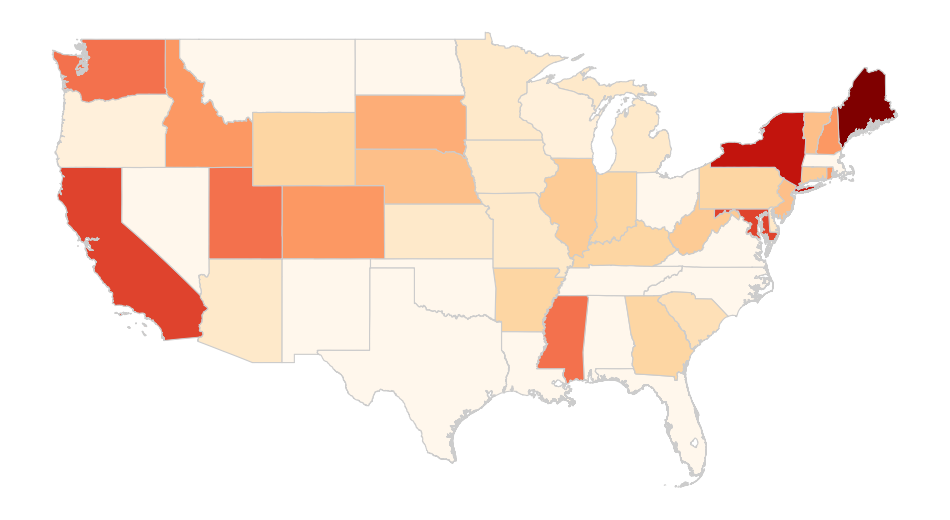

In [134]:
plot_state_leg(gdf, BILLS_SDGS_FILTERED, "Life on Land")

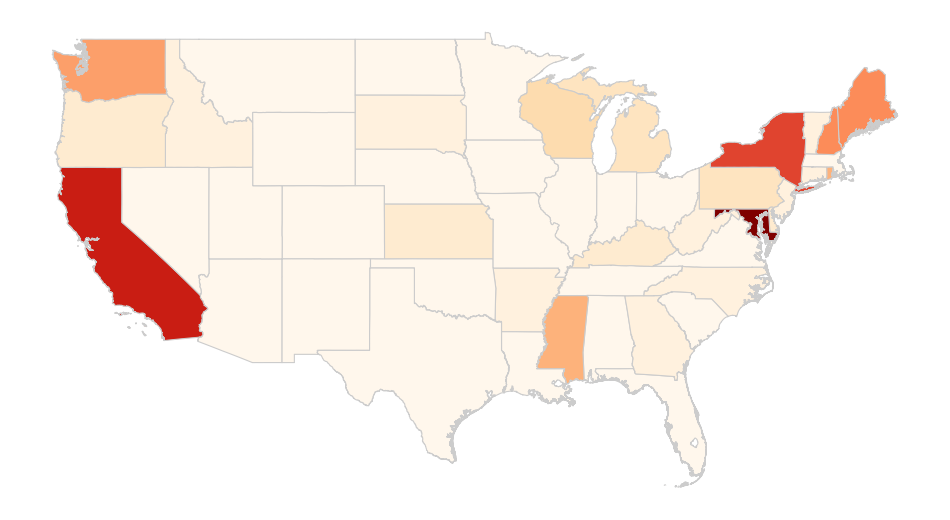

In [139]:
plot_state_leg(gdf, BILLS_SDGS_FILTERED, "Life Under Water")

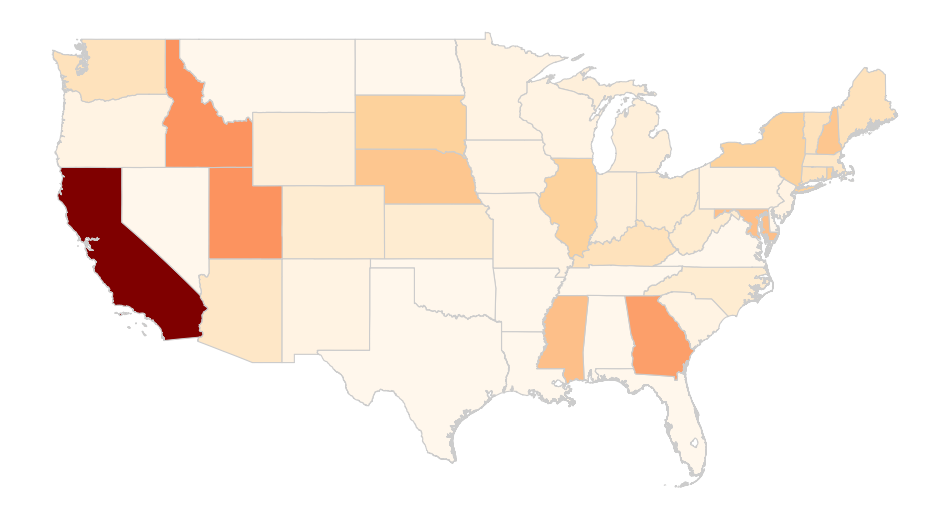

In [140]:
plot_state_leg(gdf, BILLS_SDGS_FILTERED, "Gender Equality")

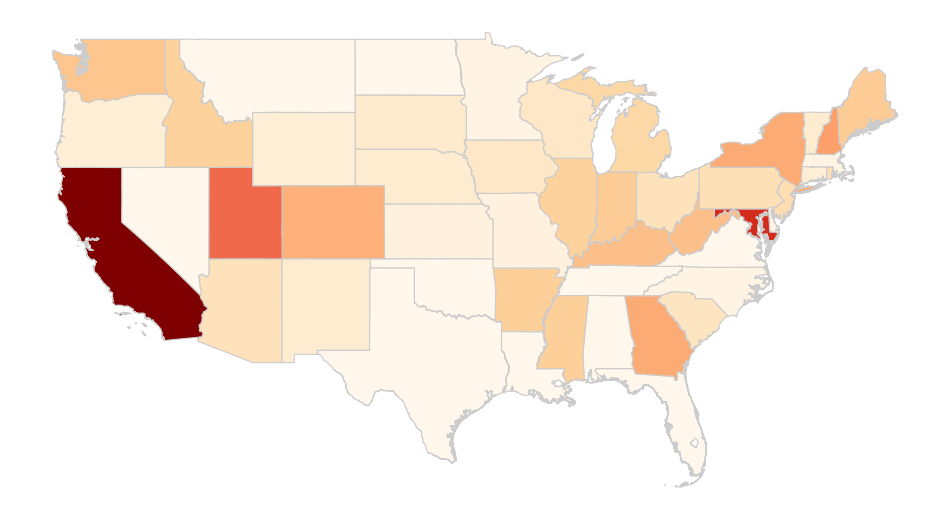

In [141]:
plot_state_leg(gdf, BILLS_SDGS_FILTERED, "Quality Education")